# Example 10 A: Cart-Pole with Wall

In [1]:
from __future__ import print_function
import sys
import threading
from time import sleep
try:
    import thread
except ImportError:
    import _thread as thread

import numpy as np
import scipy.linalg as spa
import pypolycontain as pp
import pydrake.solvers.mathematicalprogram as MP
import pydrake.solvers.gurobi as Gurobi_drake
# use Gurobi solver
global gurobi_solver, license
gurobi_solver=Gurobi_drake.GurobiSolver()
license = gurobi_solver.AcquireLicense()

import pypolycontain as pp
import pypolycontain.pwa_control as pwa

import matplotlib.pyplot as plt

In [2]:
dt=0.05
g=10
m=1
M=10
l=1

a=0.1*l
K=200

u_max=100

# state= x, v, theta, w
A=np.array([[1,dt,0,0],[0,1,-m/M*g*dt,0],[0,0,1,dt],[0,0,g/l*(1-m/M)*dt,1]])
B=np.array([0,dt/M,0,-1/M/l*dt]).reshape(4,1)

c=np.array([0,0,0,0]).reshape(4,1)
C=pp.unitbox(N=5).H_polytope
# C.H[2,0]=1
# C.h=np.array([0.15,1,0.1,  1,  u_max,   0.15,1,0.1,   1,  u_max    ]).reshape(10,1)

h_contact=np.zeros((1,5))
h_contact[0,0],h_contact[0,2]=1,1
C.H=np.vstack(( C.H , h_contact  ))
C.h=np.array([0.15,1,0.1,  1,  u_max,   0.15,1,0.1,   1,  u_max  , 0.1   ]).reshape(11,1)

S1=pwa.affine_system(A,B,c,name='free',XU=C)

A=np.array([[1,dt,0,0],[0,1,-m/M*g*dt,0],[0,0,1,dt],[-K*dt,0,g/l*(1-m/M)*dt-K*dt*l,1]])
B=np.array([0,dt/M,0,-1/M/l*dt]).reshape(4,1)

c=np.array([0,0,0,K*a*dt]).reshape(4,1)


C=pp.unitbox(N=5).H_polytope
C.H[2,0]=0
C.H[7,0]=-1
C.h=np.array([0.15,1,0.1,  1,  u_max,   0.15,1,-0.1,   1,  u_max    ]).reshape(10,1)
S2=pwa.affine_system(A,B,c,name='contact',XU=C)


myS=pwa.pwa_system()   
myS.add_mode(S1)
myS.add_mode(S2)

## A Trajectory 

trajectory optimization succesfull
contact mode change detected


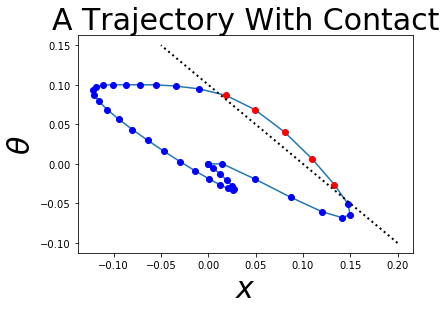

In [19]:
start=np.array([0.0,  0.3,  0,    0]).reshape(4,1)
goal=np.zeros((4,1))
T=40
# x,u,mu=point_trajectory(myS,start,T,goal,Q=np.eye(2)*100)
# try:
x,u,mu=pwa.point_trajectory(myS,start,T,goal,Q=np.eye(4)*100,R=np.eye(1))
mu[T,'free'],mu[T,'contact']=1,1
plt.plot( [x[t][0] for t in range(T+1)] , [x[t][2] for t in range(T+1)] )
plt.plot( [x[t][0] for t in range(T+1) if mu[t,'free']==0] , \
         [x[t][2] for t in range(T) if mu[t,'free']==0],'o',\
         color='red')
plt.plot( [x[t][0] for t in range(T+1) if mu[t,'free']==1] , \
         [x[t][2] for t in range(T+1) if mu[t,'free']==1],'o',\
         color='blue')
plt.plot([0.2,-0.05],[-0.1,0.15] ,LineWidth=2,linestyle=':',color='black')
plt.xlabel(r'$x$',FontSize=30)
plt.ylabel(r'$\theta$',FontSize=30)
plt.title(r'A Trajectory With Contact',FontSize=30)
xS=x

In [4]:
# T=35
# x0=np.array([0.0,  0.3,  0,    0]).reshape(4,1)
# F,_,_,_,_=pwa.extend(myS,x0,T,[pp.zonotope(G=np.eye(4)*0.001)],H_rep=False,color='red')
# fig,ax=plt.subplots()
# pp.visualize(F,fig=fig,ax=ax,a=0.01,alpha=0.9)   
# ax.set_xlabel(r'$x$',FontSize=30)
# ax.set_ylabel(r'${\theta}$',FontSize=30)
# ax.set_title('A Polytopic Trajectory',FontSize=30)
# ax.plot([0.2,-0.2],[-0.1,0.3],LineWidth=1,linestyle=':',color='black')

## Building The Tree

In [5]:
def sampler(i):
    L=np.array([0.1,1,0.1,1])
    if np.random.random()<0.3:
        return xS[np.random.randint(0,T)].reshape(4,1)
    else:
        return np.random.uniform(-L,L).reshape(4,1)    

In [6]:
def quit_function(fn_name):
    # print to stderr, unbuffered in Python 2.
    print('{0} took too long'.format(fn_name), file=sys.stderr)
    sys.stderr.flush() # Python 3 stderr is likely buffered.
    thread.interrupt_main() # raises KeyboardInterrupt

def exit_after(s):
    '''
    use as decorator to exit process if 
    function takes longer than s seconds
    '''
    def outer(fn):
        def inner(*args, **kwargs):
            timer = threading.Timer(s, quit_function, args=[fn.__name__])
            timer.start()
            try:
                result = fn(*args, **kwargs)
            finally:
                timer.cancel()
            return result
        return inner
    return outer


# @exit_after(15)    
# def extend(start,T,list_of_nodes):
#     color=(np.random.random(),np.random.random(),np.random.random())
#     x,u,mu,G,theta=pwa.polytopic_trajectory(myS, start, T, list_of_nodes)
#     Z={t: pp.zonotope(x=x[t],G=G[t],color=color) for t in range(T+1)}
#     funnel=[None]*T
#     H_funnel=[None]*T
#     contact_free=True
#     for t in range(T):
#         if mu[t,"contact"]==1:
#             contact_free=False
#             break
#     if contact_free:
#         print("it was contact free!")
#         funnel[0]=Z[0]
#         for t in range(T):
#             funnel[0]=pp.convex_hull(funnel[0], Z[t+1])
#         funnel[0].color=color
#         H_funnel=[pp.ray_shooting_hyperplanes(funnel[0],N=500,tol=1e-5)]
#         funnel=[funnel[0]]
#     else:
#         print("Oh it had contact")
#         for t in range(T):
#             funnel[t]=pp.convex_hull(Z[t], Z[t+1])
#             funnel[t].color=color
#             H_funnel[t]=pp.ray_shooting_hyperplanes(funnel[t],N=500,tol=1e-5)
#     return funnel,H_funnel,x,mu,G  

def extend(start,T,list_of_nodes):
    color=(np.random.random(),np.random.random(),np.random.random())
    x,u,mu,G,theta=pwa.polytopic_trajectory(myS, start, T, list_of_nodes)
    Z={t: pp.zonotope(x=x[t],G=G[t],color=color) for t in range(T+1)}
    funnel=[None]*T
    H_funnel=[None]*T
    for t in range(T):
        funnel[t]=pp.convex_hull(Z[t], Z[t+1])
        funnel[t].color=color
        H_funnel[t]=pp.ray_shooting_hyperplanes(funnel[t],N=500,tol=1e-5)
    return funnel,H_funnel,x,mu,G   

In [7]:
T_synthesis=6

import pickle
(H,h)=pickle.load(open('cart_pole_inner_H.pkl','rb'))
Omega=pp.H_polytope(H, h)

list_of_H_polytopes=[Omega]
list_of_nodes=[Omega]
list_of_all_nodes=[Omega]
stop_sampling=False
sample=lambda i:sampler(i)
branch=0
trajectory={}
i=0
while branch<70:
    i+=1
    print("i:",i, branch)
    while not stop_sampling:
        x0=sample(i)
        flag=pwa.in_the_tree(x0,list_of_H_polytopes)
        # flag=False
        stop_sampling=not flag
    try:
        print("sample:",x0.T)
        x,u,mu=pwa.point_trajectory(myS,x0,T=30,goal=Omega,Q=np.eye(4)*0,R=np.eye(1)*0)
        Y,YY,xx,mumu,G=extend(x0,T_synthesis,list_of_nodes)
        trajectory[branch]=(x,u,mu,xx,mumu,G)
        # Y,YY=extend(x0,T,[Omega])
        list_of_nodes.extend(Y[0:min(2,len(Y))])
        list_of_all_nodes.extend(Y)
        list_of_H_polytopes.extend(YY)
        branch+=1
    except:
        print('failed to extend')
    stop_sampling=False

i: 1 0
sample: [[ 0.07092196 -0.59653732  0.02403366 -0.92815275]]
trajectory optimization failed
failed to extend
i: 2 0
sample: [[-0.04455041 -0.80285259 -0.06563064 -0.65221602]]
trajectory optimization failed
failed to extend
i: 3 0
sample: [[-0.00175373  0.68670624  0.08270563  0.52030233]]
trajectory optimization failed
failed to extend
i: 4 0
sample: [[-0.07461141  0.2171928   0.04820837  0.62789857]]
trajectory optimization failed
failed to extend
i: 5 0
sample: [[-0.1184629  -0.06429157  0.09760964 -0.07905556]]
trajectory optimization succesfull
disjunctive subset with 1 circumbodies
**********  Set up a mixed-integer optimization problem **********
polytopic trajectory optimization succesfull
i: 6 1
sample: [[ 0.04189141 -0.35536249 -0.02701298  0.06767547]]
trajectory optimization failed
failed to extend
i: 7 1
sample: [[-0.06171182 -0.13708749  0.01975396  0.48510867]]
trajectory optimization failed
failed to extend
i: 8 1
sample: [[-0.0220033  -0.66111188  0.08397752  0.3

## Visualization

### Projection

projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dim

/usr/lib/python3/dist-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


Text(0.5, 1.0, '50 Branches 301 AH-polytopes \nprojected into $x-\\theta$ planes')

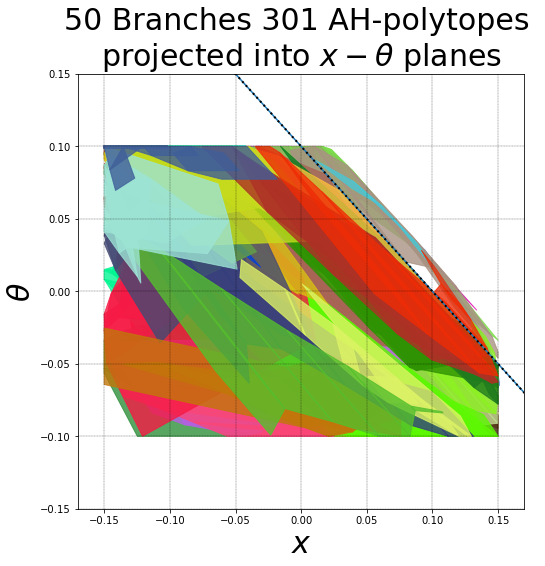

In [8]:
fig,ax=plt.subplots()
pp.visualize([Omega]+list_of_all_nodes,a=0.01,ax=ax,fig=fig,tuple_of_projection_dimensions=(0,2),\
             title='Hybrid MPC Feasible Set %d Branches'%branch)
ax.plot([1,-1],[-0.9,1.1]) 
ax.set_xlim([-0.17,0.17])
ax.set_ylim([-0.15,0.15])
# Synthesis
ax.plot([0.2,-0.2],[-0.1,0.3] ,LineWidth=2,linestyle=':',color='black')
ax.set_xlabel(r'$x$',FontSize=30)
ax.set_ylabel(r'$\theta$',FontSize=30)
ax.set_title(r"""%d Branches %d AH-polytopes 
projected into $x-\theta$ planes"""%(branch,len(list_of_all_nodes)),FontSize=30)

### Slice 

projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dim

Text(0.5, 1.0, '50 Branches 301 AH-polytopes \nsliced with $x-\\theta$ planes')

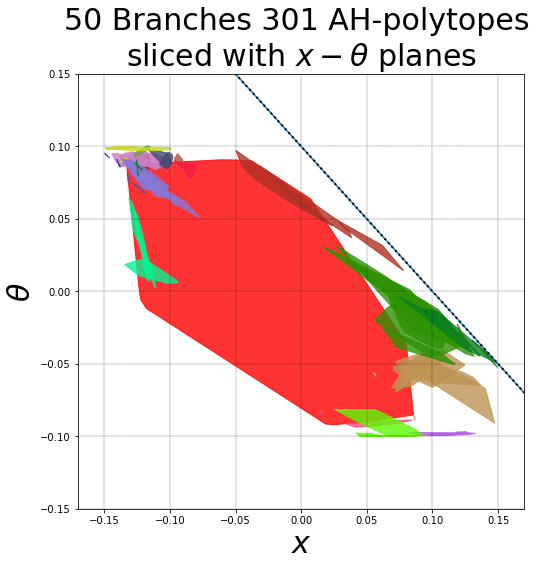

In [15]:
slicer=pp.unitbox(4).H_polytope    
slicer.h[1,0],slicer.h[3,0],slicer.h[5,0],slicer.h[7,0]=0.01,0.01,0.01,0.01

sliced=[pp.intersection(Q,slicer) for Q in list_of_all_nodes]
i=0
for Q in sliced:
    Q.color=list_of_all_nodes[i].color
    i+=1
fig,ax=plt.subplots()
# for Q in sliced:
#        print( pp.check_non_empty(Q))
pp.visualize([Q for Q in sliced if pp.check_non_empty(Q)],\
             a=0.01,ax=ax,fig=fig,tuple_of_projection_dimensions=(0,2),\
                 title='Hybrid MPC Feasible Set')
ax.plot([1,-1],[-0.9,1.1]) 
ax.set_xlim([-0.17,0.17])
ax.set_ylim([-0.15,0.15])        
ax.plot([0.2,-0.2],[-0.1,0.3] ,LineWidth=2,linestyle=':',color='black')
ax.set_xlabel(r'$x$',FontSize=30)
ax.set_ylabel(r'$\theta$',FontSize=30)
ax.set_title(r"""%d Branches %d AH-polytopes 
sliced with $x-\theta$ planes"""%(branch,len(list_of_all_nodes)),FontSize=30)

## A Trajectory

projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dimensions
projection on  0  and  2 dim

Text(0.5, 1.0, 'A Trajectory With Contact')

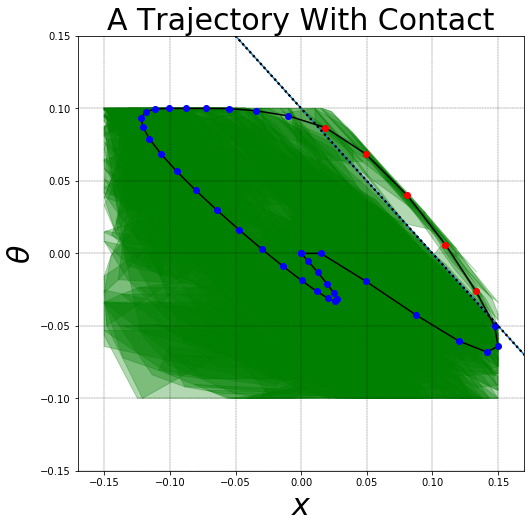

In [21]:
fig,ax=plt.subplots()

for Q in list_of_all_nodes:
    Q.color='green'
    
pp.visualize(list_of_all_nodes,a=0.01,ax=ax,fig=fig,tuple_of_projection_dimensions=(0,2),\
             title='Hybrid MPC Feasible Set %d Branches'%branch, alpha=0.3)


ax.plot([1,-1],[-0.9,1.1]) 
ax.set_xlim([-0.17,0.17])
ax.set_ylim([-0.15,0.15])
# Synthesis
ax.plot([0.2,-0.2],[-0.1,0.3] ,LineWidth=2,linestyle=':',color='black')
ax.set_xlabel(r'$x$',FontSize=30)
ax.set_ylabel(r'$\theta$',FontSize=30)


x=xS

mu[T,'free'],mu[T,'contact']=1,1
ax.plot( [x[t][0] for t in range(T+1)] , [x[t][2] for t in range(T+1)], color='black' )
ax.plot( [x[t][0] for t in range(T+1) if mu[t,'free']==0] , \
         [x[t][2] for t in range(T) if mu[t,'free']==0],'o',\
         color='red')
ax.plot( [x[t][0] for t in range(T+1) if mu[t,'free']==1] , \
         [x[t][2] for t in range(T+1) if mu[t,'free']==1],'o',\
         color='blue')
ax.plot([0.2,-0.05],[-0.1,0.15] ,LineWidth=2,linestyle=':',color='black')

ax.set_title(r'A Trajectory With Contact',FontSize=30)

### Studying Coverage
We generate random points and see 

In [ ]:
Trials=500
covered=0
false_positive=0
feasible=0
L=np.array([0.1,1,0.1,1])
for N in range(Trials):
    x0=np.random.uniform(-L,L).reshape(4,1)
    print(N)
    try:
        x,u,mu=pwa.point_trajectory(myS,x0,T=40,goal=np.zeros((4,1)),Q=np.eye(4)*1)
        feasible+=1
        covered+=pwa.in_the_tree(x0,list_of_H_polytopes)
    except:
        false_positive+=pwa.in_the_tree(x0,list_of_H_polytopes)
print("feasible: %d    covered: %d"%(feasible,covered)) 
print("infeasible: %d    false positive: %d"%(Trials-feasible,false_positive)) 

In [22]:
print("feasible: %d    covered: %d"%(feasible,covered)) 
print("infeasible: %d    false positive: %d"%(Trials-feasible,false_positive)) 

feasible: 107    covered: 54
infeasible: 393    false positive: 6
